In [1]:
import sys
from pathlib import Path

#Add path to parent folder for imports
sys.path.append(str(Path.cwd().parent))

In [2]:
from tqdm import tqdm 
import torch
import torch.nn as nn
import torch.optim as optim
from timebudget import timebudget

def double_conv(in_channels, out_channels):
    '''Performs two successive convolution operations
    '''
    conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(inplace=True)
    )
    return conv

def crop_tensor(tensor, target_tensor):
    '''Crop the tensor xdim and ydim.
     - Assumes sizes are divisible by 2
     - Assumes tensor sizes are [batch,channels,xdim,ydim]
    '''
    tensor_size = tensor.size()[2]
    target_tensor_size = target_tensor.size()[2]
    delta = (tensor_size-target_tensor_size)//2
    target = tensor[:, :, delta:tensor_size-delta, delta:tensor_size-delta]
    return target


class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.maxpool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_1 = double_conv(2, 16)
        self.down_conv_2 = double_conv(16, 32)
        self.down_conv_3 = double_conv(32, 64)
        self.down_conv_4 = double_conv(64, 128)

        self.up_trans_1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up_conv_1 = double_conv(128, 64)

        self.up_trans_2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.up_conv_2 = double_conv(64, 32)

        self.up_trans_3 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.up_conv_3 = double_conv(32, 16)

        self.up_trans_4 = nn.ConvTranspose2d(16, 8, kernel_size=2, stride=2)
        self.up_conv_4 = double_conv(16, 8)

        self.out = nn.Conv2d(16, 2, kernel_size=1)
        self.sig = nn.Sigmoid()
        return

    def forward(self, image):
        x1 = self.down_conv_1(image)
        #print(x1.size())

        x2 = self.maxpool_2x2(x1)
        x2 = self.down_conv_2(x2)
        #print(x2.size())

        x3 = self.maxpool_2x2(x2)
        x3 = self.down_conv_3(x3)
        #print(x3.size())

        x4 = self.maxpool_2x2(x3)
        x4 = self.down_conv_4(x4)
        #print(x4.size())

        x6 = self.up_trans_1(x4)
        #print(x6.size())
        
        x3 = crop_tensor(tensor=x3, target_tensor=x6)
        x7 = self.up_conv_1(torch.cat(tensors=[x3, x6], dim=1))
        #print(x7.size())
        
        x7 = self.up_trans_2(x7)
        x2 = crop_tensor(tensor=x2, target_tensor=x7)
        x8 = self.up_conv_2(torch.cat(tensors=[x2, x7], dim=1))
        #print(x8.size())

        x8 = self.up_trans_3(x8)
        x1 = crop_tensor(tensor=x1, target_tensor=x8)
        x9 = self.up_conv_3(torch.cat(tensors=[x1, x8], dim=1))
        #print(x9.size())

        x = self.sig(self.out(x9))
        #print(x.size())
        return x

In [13]:
#Test data
from skimage.filters import gaussian
import scipy.io as sio
D = sio.loadmat('../testdata/im260x260.mat',squeeze_me=True)
IM = D['im'].astype(float)

im_0_gauss = gaussian(IM[0,:,:], sigma=3)
im_1_gauss = gaussian(IM[1,:,:], sigma=3)
im_0_gauss = im_0_gauss/np.max(im_0_gauss)
im_1_gauss = im_1_gauss/np.max(im_1_gauss)
L = np.array(np.concatenate([np.expand_dims(im_0_gauss,0),np.expand_dims(im_1_gauss,0)],axis = 0)>0.5).astype('uint8')
L = L.astype(float)

IM_ = np.expand_dims(IM,0)
L_ = np.expand_dims(L,0)

In [14]:
IM_.shape

(1, 2, 260, 260)

In [15]:
L_.shape

(1, 2, 260, 260)

In [3]:
unet = UNet()
optimizer = optim.Adam(unet.parameters())
mse = torch.nn.MSELoss()

cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
if cuda:
    unet.cuda()
    mse.cuda()

with timebudget('Training with GPU'):
    for step in range(1000):  # loop over the dataset multiple times
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = unet(Tensor(IM_))
        #loss = torch.sum(torch.square(outputs - )
        target = crop_tensor(Tensor(L_), outputs)
        loss = mse(outputs, target)

        loss.backward()
        optimizer.step()

        # print statistics
        if step % 100 == 0:
            print('Step {:04d} training loss: {:0.6f}'.format(step,loss.item()))

Step 0000 training loss: 0.252556
Step 0100 training loss: 0.065532
Step 0200 training loss: 0.022408
Step 0300 training loss: 0.009913
Step 0400 training loss: 0.005367
Step 0500 training loss: 0.003287
Step 0600 training loss: 0.002214
Step 0700 training loss: 0.001598
Step 0800 training loss: 0.001207
Step 0900 training loss: 0.000943
Training with GPU took 19.550sec


In [4]:
#Checks - plot 
input_size = 260
output_size = 172
crop_size = (input_size-output_size)//2

In [5]:
#tensors have format: [index,channel,height,width]

#Tensors have to be brought to cpu before conversion to numpy
if torch.cuda.is_available():
    lbl = crop_tensor(Tensor(L_), outputs).cpu().numpy()
    img = Tensor(IM_).cpu().numpy()[:,:,crop_size:-crop_size,crop_size:-crop_size]
    pred = outputs.cpu().detach().numpy()
else:
    lbl = crop_tensor(Tensor(L_), outputs).numpy()
    img = Tensor(IM_).numpy()[:,:,crop_size:-crop_size,crop_size:-crop_size]
    pred = outputs.cpu().detach().numpy()

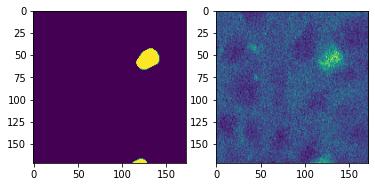

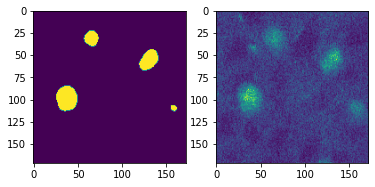

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.subplot(121)
plt.imshow(lbl[0,0,:,:])
plt.subplot(122)
plt.imshow(img[0,0,:,:])

plt.figure()
plt.subplot(121)
plt.imshow(lbl[0,1,:,:])
plt.subplot(122)
plt.imshow(img[0,1,:,:])
plt.show()

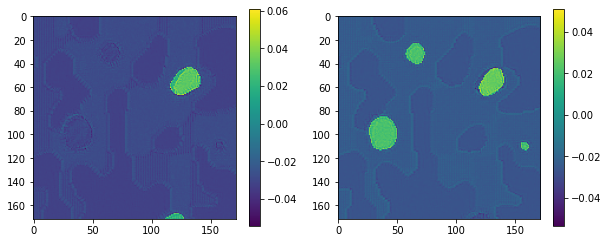

In [7]:
#Checks - plot differences between label and pred
plt.figure(figsize = (10,4))
plt.subplot(121)
plt.imshow(lbl[0,0,:,:]-pred[0,0,:,:])
plt.colorbar()

plt.subplot(122)
plt.imshow(lbl[0,1,:,:]-pred[0,1,:,:])
plt.colorbar()
plt.show()

In [11]:
import numpy as np
from sys import getsizeof
a = [0.0] * 2048 * 2048
b = np.array(a)
getsizeof(a)
sizeim = b.nbytes

print(sizeim/1024/1024, 'Mb per image')
print(40*(sizeim/(1024**3)), 'Gb for 2x for channels + 2x for labels')

32.0 Mb per image
1.25 Gb for 2x for channels + 2x for labels


#### Dataset/dataloader/sampler for full dataset:

In [11]:
import sys
from pathlib import Path
#Add path to parent folder for imports
sys.path.append(str(Path.cwd().parent))

import torch 
torch.manual_seed(0)
from utils.data import ai224_RG, MyRandomSampler
from torch.utils.data import DataLoader


batch_size=12
n_batches_per_epoch=10
num_samples = n_batches_per_epoch*batch_size

train_dataset = ai224_RG(pad=130,
                         patch_size = 260,
                         im_path='/Users/fruity/Dropbox/AllenInstitute/CellCount/dat/raw/Unet_tiles_082020/',
                         lbl_path='/Users/fruity/Dropbox/AllenInstitute/CellCount/dat/proc/Unet_tiles_082020/')

train_sampler = MyRandomSampler(n_tiles=train_dataset.n_tiles, 
                                max_x=train_dataset.tile_shape_orig[0], 
                                max_y=train_dataset.tile_shape_orig[1], 
                                num_samples=num_samples)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False,
                            sampler=train_sampler, drop_last=True, pin_memory=True)

train_datagen = iter(train_dataloader)
batch = next(train_datagen)

print(batch['im'].shape)
print(batch['lbl'].shape)

torch.Size([12, 2, 260, 260])
torch.Size([12, 6, 260, 260])


### Testing Transforms
 - https://pytorch.org/docs/stable/_modules/torchvision/transforms/transforms.html

In [12]:
%matplotlib inline
# import torch
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# tensor = lambda x: torch.tensor(x).to(dtype=torch.float32).to(device)
# tensor_ = lambda x: torch.as_tensor(x).to(dtype=torch.float32).to(device)

User warning in torchvision when converting from PIL image to tensor
``` 
/Users/fruity/miniconda3/envs/torch16/lib/python3.7/site-packages/torchvision/transforms/functional.py:109: UserWarning: Given numpy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1595629430416/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.as_tensor(np.asarray(pic))
```
  
See for solution:  
- https://github.com/pytorch/vision/issues/2194 
- https://discuss.pytorch.org/t/userwarning-the-given-numpy-array-is-not-writeable/78748/7

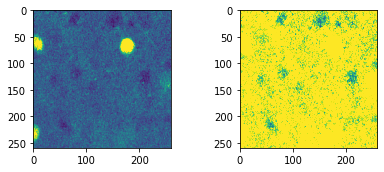

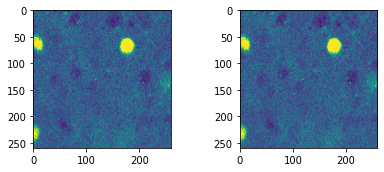

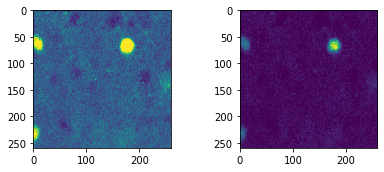

In [13]:
from utils.transforms import My_RandomGamma
for gamma in [0.7,1.0,1.3]:
    gam = My_RandomGamma(p=1.0,gamma_list=[gamma])
    sample = {'im':batch['im'][1],'lbl':batch['lbl'][1]}
    sample_ = gam(sample)

    plt.figure(figsize=(6,2.5))
    plt.subplot(121)
    plt.imshow(np.squeeze(sample['im'].detach().numpy()[0,:,:]),vmin=0,vmax=10)
    plt.subplot(122)
    plt.imshow(np.squeeze(sample_['im'].detach().numpy()[0,:,:]),vmin=0,vmax=10)
    plt.tight_layout()
    plt.show()

In [25]:
from utils.transforms import MyRandomHorizontalFlip
hflip = MyRandomHorizontalFlip(1.0)
sample = {'im':batch['im'][1],'lbl':batch['lbl'][1]}
sample_ = hflip(sample)
plt.figure(figsize=(6,2.5))
plt.subplot(121)
plt.imshow(np.squeeze(sample['im'].detach().numpy()[0,:,:]),vmin=0,vmax=10)
plt.subplot(122)
plt.imshow(np.squeeze(sample_['im'].detach().numpy()[0,:,:]),vmin=0,vmax=10)
plt.tight_layout()
plt.show()

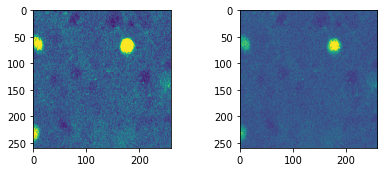

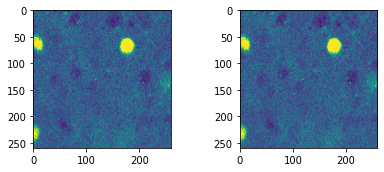

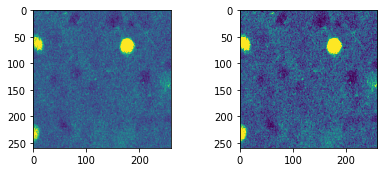

In [15]:
from utils.transforms import My_RandomContrast
for c in [0.5,1.0,1.5]:
    con = My_RandomContrast(p=1.0,contrast_factor_list=[c])
    sample = {'im':batch['im'][1],'lbl':batch['lbl'][1]}
    sample_ = con(sample)

    plt.figure(figsize=(6,2.5))
    plt.subplot(121)
    plt.imshow(np.squeeze(sample['im'].detach().numpy()[0,:,:]),vmin=0,vmax=10)
    plt.subplot(122)
    plt.imshow(np.squeeze(sample_['im'].detach().numpy()[0,:,:]),vmin=0,vmax=10)
    plt.tight_layout()
    plt.show()

### Composing transforms

In [1]:
import sys
from pathlib import Path
#Add path to parent folder for imports
sys.path.append(str(Path.cwd().parent))

import torch 
torch.manual_seed(0)
from torch.utils.data import DataLoader
from torchvision.transforms import Compose
from utils.data import ai224_RG, MyRandomSampler
from utils.transforms import MyRandomFlip,My_RandomContrast,My_RandomGamma

In [2]:
batch_size=12
n_batches_per_epoch=10
num_samples = n_batches_per_epoch*batch_size
np_transform = MyRandomFlip(p=1.0)
transforms = Compose([My_RandomContrast(p=1.0,contrast_factor_list=[1.5]),
                      My_RandomGamma(p=1.0,gamma_list=[1.3])])

train_dataset = ai224_RG(pad=130,
                         patch_size = 260,
                         im_path='/Users/fruity/Dropbox/AllenInstitute/CellCount/dat/raw/Unet_tiles_082020/',
                         lbl_path='/Users/fruity/Dropbox/AllenInstitute/CellCount/dat/proc/Unet_tiles_082020/',
                         np_transform = np_transform,
                         torch_transforms = transforms)

train_sampler = MyRandomSampler(n_tiles=train_dataset.n_tiles, 
                                max_x=train_dataset.tile_shape_orig[0], 
                                max_y=train_dataset.tile_shape_orig[1], 
                                num_samples=num_samples)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False,
                            sampler=train_sampler, drop_last=True, pin_memory=True)

train_datagen = iter(train_dataloader)
batch = next(train_datagen)

print(batch['im'].shape)
print(batch['lbl'].shape)

torch.Size([12, 2, 260, 260])
torch.Size([12, 6, 260, 260])


/Users/fruity/miniconda3/envs/torch16/lib/python3.7/site-packages/torchvision/transforms/functional.py:109: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1595629430416/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.as_tensor(np.asarray(pic))


In [ ]:
train_datagen = iter(train_dataloader)
from timebudget import timebudget
with timebudget('10 batches batch'):
    for i in range(10):
        batch = next(train_datagen)

## Updated UNet

In [1]:
from tqdm import tqdm 
import torch
import torch.nn as nn
import torch.optim as optim
from timebudget import timebudget

def double_conv(in_channels, out_channels):
    '''Performs two successive convolution operations
    '''
    conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(inplace=True)
    )
    return conv

def crop_tensor(tensor, target_tensor):
    '''Crop the tensor xdim and ydim.
     - Assumes sizes are divisible by 2
     - Assumes tensor sizes are [batch,channels,xdim,ydim]
    '''
    tensor_size = tensor.size()[2]
    target_tensor_size = target_tensor.size()[2]
    delta = (tensor_size-target_tensor_size)//2
    target = tensor[..., delta:tensor_size-delta, delta:tensor_size-delta]
    return target


class UNet2(nn.Module):
    def __init__(self):
        super(UNet2, self).__init__()
        self.maxpool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_1 = double_conv(2, 16)
        self.down_conv_2 = double_conv(16, 32)
        self.down_conv_3 = double_conv(32, 64)
        self.down_conv_4 = double_conv(64, 128)

        self.up_trans_1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up_conv_1 = double_conv(128, 64)

        self.up_trans_2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.up_conv_2 = double_conv(64, 32)

        self.up_trans_3 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.up_conv_3 = double_conv(32, 16)

        self.up_trans_4 = nn.ConvTranspose2d(16, 8, kernel_size=2, stride=2)
        self.up_conv_4 = double_conv(16, 8)

        self.out = nn.Conv2d(16, 6, kernel_size=1)
        self.sig = nn.Sigmoid()
        return

    def forward(self, image):
        x1 = self.down_conv_1(image)
        #print(x1.size())

        x2 = self.maxpool_2x2(x1)
        x2 = self.down_conv_2(x2)
        #print(x2.size())

        x3 = self.maxpool_2x2(x2)
        x3 = self.down_conv_3(x3)
        #print(x3.size())

        x4 = self.maxpool_2x2(x3)
        x4 = self.down_conv_4(x4)
        #print(x4.size())

        x6 = self.up_trans_1(x4)
        #print(x6.size())
        
        x3 = crop_tensor(tensor=x3, target_tensor=x6)
        x7 = self.up_conv_1(torch.cat(tensors=[x3, x6], dim=1))
        #print(x7.size())
        
        x7 = self.up_trans_2(x7)
        x2 = crop_tensor(tensor=x2, target_tensor=x7)
        x8 = self.up_conv_2(torch.cat(tensors=[x2, x7], dim=1))
        #print(x8.size())

        x8 = self.up_trans_3(x8)
        x1 = crop_tensor(tensor=x1, target_tensor=x8)
        x9 = self.up_conv_3(torch.cat(tensors=[x1, x8], dim=1))
        #print(x9.size())

        x = self.sig(self.out(x9))
        #print(x.size())
        return x

In [2]:
import sys
from pathlib import Path
#Add path to parent folder for imports
sys.path.append(str(Path.cwd().parent))

import torch 
torch.manual_seed(0)
from torch.utils.data import DataLoader
from torchvision.transforms import Compose
from utils.data import ai224_RG, MyRandomSampler
from utils.transforms import MyRandomFlip,My_RandomContrast,My_RandomGamma

batch_size=12
n_batches_per_epoch=10
num_samples = n_batches_per_epoch*batch_size
np_transform = MyRandomFlip(p=1.0)
transforms = Compose([My_RandomContrast(p=1.0,contrast_factor_list=[1.5]),
                      My_RandomGamma(p=1.0,gamma_list=[1.3])])

train_dataset = ai224_RG(pad=130,
                         patch_size = 260,
                         im_path='/home/rohan/Dropbox/AllenInstitute/CellCount/dat/raw/Unet_tiles_082020/',
                         lbl_path='/home/rohan/Dropbox/AllenInstitute/CellCount/dat/proc/Unet_tiles_082020/',
                         np_transform = np_transform,
                         torch_transforms = transforms)

train_sampler = MyRandomSampler(n_tiles=train_dataset.n_tiles, 
                                max_x=train_dataset.tile_shape_orig[0], 
                                max_y=train_dataset.tile_shape_orig[1], 
                                num_samples=num_samples)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False,
                            sampler=train_sampler, drop_last=True, pin_memory=True)


unet2 = UNet2()
optimizer = optim.Adam(unet2.parameters())
mse = torch.nn.MSELoss()

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
tensor = lambda x: torch.tensor(x).to(dtype=torch.float32).to(device)
tensor_ = lambda x: torch.as_tensor(x).to(dtype=torch.float32).to(device)

if device.type=='cuda':
    unet2.cuda()
    mse.cuda()

In [4]:
with timebudget('Training with GPU'):
    for epoch in range(100):
        loss_list = []
        train_datagen = iter(train_dataloader)
        for step in range(len(train_dataloader)):
            batch = next(train_datagen)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = unet2(tensor(batch['im']))

            target = crop_tensor(tensor(batch['lbl']), outputs)
            loss = mse(outputs, target)

            loss.backward()
            optimizer.step()
            
            loss_list.append(loss.item())

            if step == 0:
                print('\repoch {:04d} training loss: {:0.6f}'.format(epoch,np.mean(loss_list)),end='')

/home/rohan/miniconda3/envs/torch16/lib/python3.7/site-packages/torchvision/transforms/functional.py:109: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629427478/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.as_tensor(np.asarray(pic))
/home/rohan/miniconda3/envs/torch16/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


epoch 0099 training loss: 0.004569Training with GPU took 93.781sec


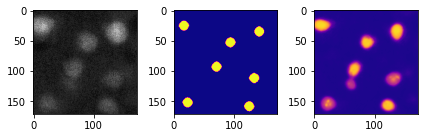

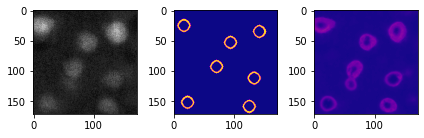

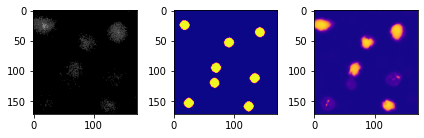

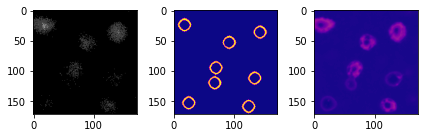

====



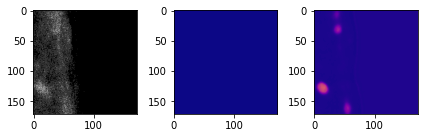

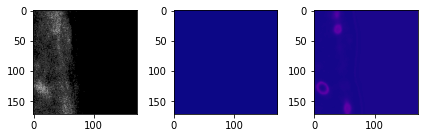

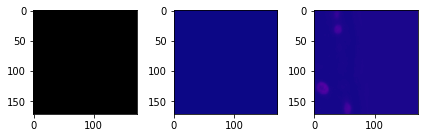

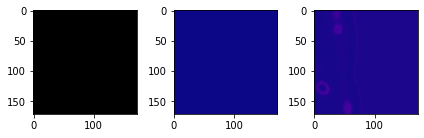

====



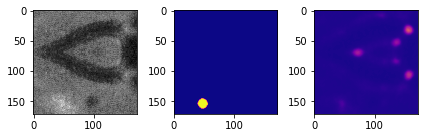

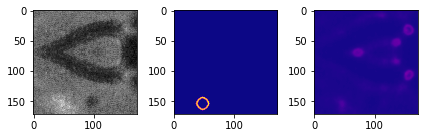

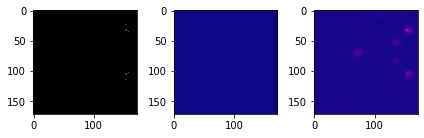

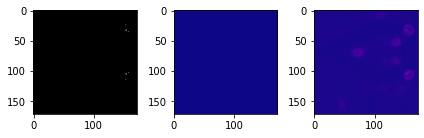

====



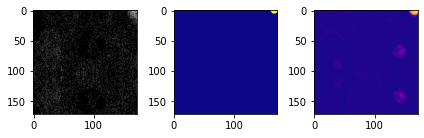

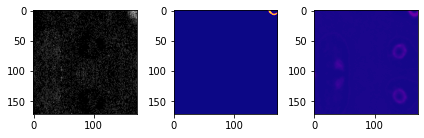

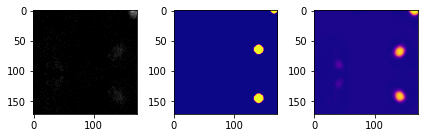

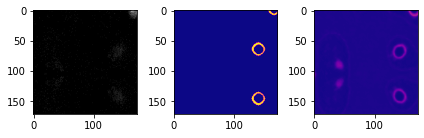

====



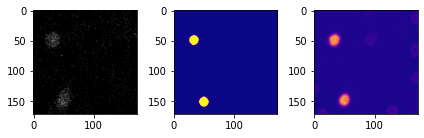

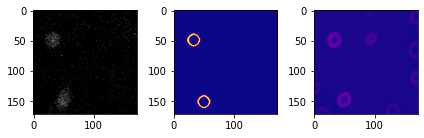

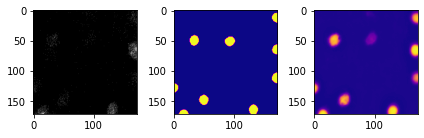

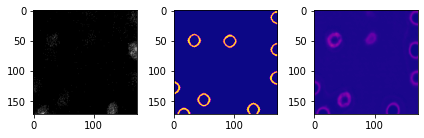

====



In [8]:
%matplotlib inline
tonumpy = lambda x: x.cpu().detach().numpy()

#Plot some examples in both channels [image: ground truth: prediction]
for i in [0,1,2,3,4]:
    for channel in [0,1]:

        plt.subplot(131)
        plt.imshow(tonumpy(crop_tensor(batch['im'].float(), outputs))[i,channel],cmap='gray')
        plt.subplot(132)
        plt.imshow(tonumpy(target)[i,2+3*channel],vmax=1,vmin=0,cmap='plasma')
        plt.subplot(133)
        plt.imshow(tonumpy(outputs)[i,2+3*channel],vmax=1,vmin=0,cmap='plasma')
        plt.tight_layout()
        plt.show()

        plt.figure()
        plt.subplot(131)
        plt.imshow(tonumpy(crop_tensor(batch['im'].float(), outputs))[i,channel],cmap='gray')
        plt.subplot(132)
        plt.imshow(tonumpy(target)[i,1+3*channel],vmax=1,vmin=0,cmap='plasma')
        plt.subplot(133)
        plt.imshow(tonumpy(outputs)[i,1+3*channel],vmax=1,vmin=0,cmap='plasma')
        plt.tight_layout()
        plt.show()
        
    print('====\n')